# Loading Trained Model

In [9]:
import torch
from src.LogViewer import LogViewer
from src.Earlystopper import EarlyStopper
from torch.optim.lr_scheduler import ReduceLROnPlateau
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR

In [10]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Model selection for CIFAR"""
NUM_LAYERS_LEVEL = 5

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0.95

"""optimizer parameters"""
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"
OPTIMIZER = "SGD"
# OPTIMIZER = "SGD_nasterov"
# OPTIMIZER = "AdamW"
# OPTIMIZER = "AdamW_amsgrad"
# OPTIMIZER = "NAdam"


file_name = ""
if DATASET == "ImageNet2012":
    file_name = f"MyResNet34_{BATCH}_{OPTIMIZER}"
    _model_name = f"MyResNet34_{DATASET}_{BATCH}_{OPTIMIZER}"
else:
    file_name = f"MyResNet{NUM_LAYERS_LEVEL*6+2}_{BATCH}_{OPTIMIZER}"
    _model_name = f"MyResNet{NUM_LAYERS_LEVEL*6+2}_{DATASET}_{BATCH}_{OPTIMIZER}"

if SPLIT_RATIO != 0:
    _model_name += f"_{int(SPLIT_RATIO*100)}"
    file_name += f"_{int(SPLIT_RATIO*100)}"

In [11]:
checkpoint = torch.load(
    "models/"+_model_name+"/"+file_name + ".pth.tar",
    map_location=lambda storage, loc: storage.cuda("cuda"),
)

logs = checkpoint["logs"]

print("Suceessfully loaded the All setting and Log file.")

Suceessfully loaded the All setting and Log file.


In [12]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(
        num_classes=10,
        num_layer_factor=NUM_LAYERS_LEVEL,
        Downsample_option="A",
    ).to("cuda")
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")

elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(num_classes=1000, Downsample_option="B").to("cuda")
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")

if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4
    )
elif OPTIMIZER == "SGD_nasterov":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True
    )
elif OPTIMIZER == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "AdamW_amsgrad":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4, amsgrad=True)
elif OPTIMIZER == "NAdam":
    optimizer = torch.optim.NAdam(model.parameters(), weight_decay=1e-4)

# %% [markdown]
# ## (3) Define Early Stopping

# %%
earlystopper = EarlyStopper(patience=777, model=model, file_name=file_name)

# %% [markdown]
# ## (4) Define Learning Rate schedualer

# %%
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=777,
    factor=0.1,
    verbose=True,
    threshold=1e-4,
    cooldown=777,
)

optimizer.load_state_dict(checkpoint["optimizer"])
scheduler.load_state_dict(checkpoint["scheduler"])
earlystopper.load_state_dict(checkpoint["earlystopper"])
model.load_state_dict(checkpoint["model"])
torch.save(model.state_dict(), file_name + ".pth")

ResNet-32 for CIFAR10 is loaded.


In [13]:
print("now lr:", optimizer.param_groups[0]["lr"])
print("earlystop counter:", earlystopper.early_stop_counter)
print("bad epoch counter:", scheduler.num_bad_epochs)
print("scheduler parience:", scheduler.patience)
print("scheduler cooldown counter:", scheduler.cooldown_counter)


now lr: 0.00010000000000000003
earlystop counter: 69
bad epoch counter: 0
scheduler parience: 10
scheduler cooldown counter: 23


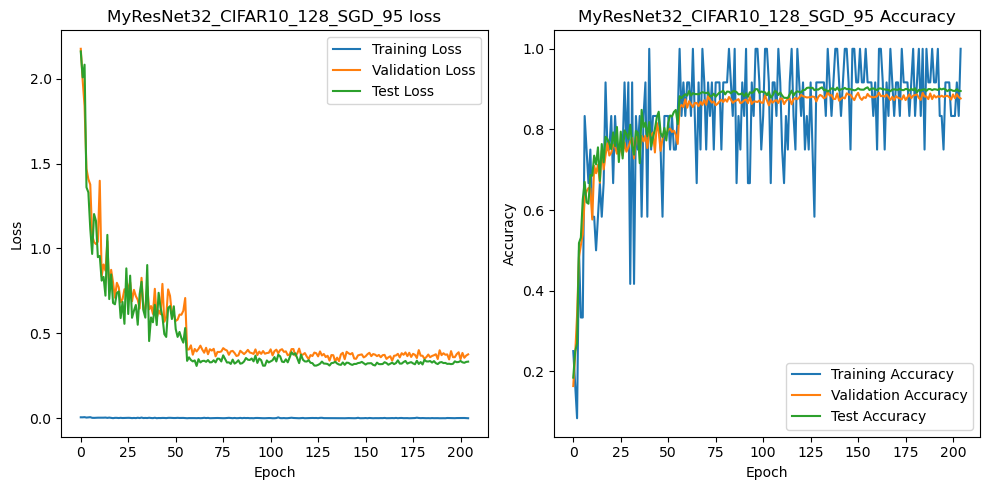

In [14]:
viewer = LogViewer(logs)
# viewer.draw(start=4980, range=200)
viewer.draw(save_name=_model_name)


In [15]:
viewer.print_len()

Num of train logs :  205
Num of train logs :  205
Num of valid logs :  205
Num of valid logs :  205
Num of test  logs :  205
Num of test  logs :  205
Num of lr    logs :  205


In [16]:
viewer.print_all()

1 epoch: train_loss=0.0056, train_acc=0.2500, test_loss=2.1601, test_acc=0.1842, valid_loss=2.1756, valid_acc=0.1632, lr=0.1000
2 epoch: train_loss=0.0055, train_acc=0.1667, test_loss=2.0074, test_acc=0.2489, valid_loss=1.9896, valid_acc=0.2424, lr=0.1000
3 epoch: train_loss=0.0064, train_acc=0.0833, test_loss=2.0821, test_acc=0.2691, valid_loss=1.8391, valid_acc=0.3384, lr=0.1000
4 epoch: train_loss=0.0040, train_acc=0.5000, test_loss=1.3600, test_acc=0.5181, valid_loss=1.4690, valid_acc=0.4832, lr=0.1000
5 epoch: train_loss=0.0051, train_acc=0.3333, test_loss=1.3300, test_acc=0.5317, valid_loss=1.4080, valid_acc=0.5128, lr=0.1000
6 epoch: train_loss=0.0062, train_acc=0.3333, test_loss=1.1169, test_acc=0.6263, valid_loss=1.3762, valid_acc=0.5396, lr=0.1000
7 epoch: train_loss=0.0025, train_acc=0.8333, test_loss=0.9675, test_acc=0.6697, valid_loss=1.0775, valid_acc=0.6292, lr=0.1000
8 epoch: train_loss=0.0022, train_acc=0.7500, test_loss=1.2025, test_acc=0.6191, valid_loss=1.0377, vali

- 주피터노트북 output set
- @tag:notebookOutputLayout